In [1]:
# Necessary installs
%pip install torch torchvision
%pip install tqdm
%pip install ipywidgets
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: torch in c:\users\asifa\appdata\local\programs\python\python311\lib\site-packages (2.1.0+cu121)




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Relevant torch imports, TQDM required for visualization
import os
import torch
import time
import copy
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import ParameterGrid


print("Package importing successful.")

Package importing successful.


# Training Configuration 

In [3]:
# Defining Dataset directory and transformation settings
model_dataset_dir = './images/'
model_batch_size = 16
model_num_workers = 4

# Training settings
model_num_epochs = 35
model_learning_rate = 0.001
model_momentum = 0.9
model_weight_decay=1e-4

# Scheduler settings
model_step_size = 6
model_gamma = 0.1

# Model settings
model_save_path = 'saved_models/final_model_weights.tar'

# Data transformations
# Using mean and standard deviation of imagenet for the normaalization.
model_data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
    'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
}

# Loading and analysing the dataset
We are using the PlantNet-300K dataset. Ensure that the set up instructions for model training mentioned in README.md in the root project directory is complete. Specifically, you need to download the dataset, and extract the image folder to this folder director, so there should be a folder in `./model_training/images/` which would contain all the training and validation image sets.

Some parts of the implementation are inspired from the official implemention of Model training for PlantNet300K, available at: https://github.com/plantnet/PlantNet-300K

In [ ]:
# Setting image dataset for training and validation
image_datasets = {
    data: ImageFolder(os.path.join(model_dataset_dir, data), model_data_transforms[data]) 
    for data in ['train', 'val']
}

In [5]:
# Identifying the classes with low image data
classes = np.array(image_datasets['train'].targets)
unique_classes, counts = np.unique(classes, return_counts=True)

# Calculate average samples per class
average_samples = np.mean(counts)
print(f"Average number of samples per class: {average_samples:.0f}")

# the class with the maximum and minimum samples
max_samples_index = np.argmax(counts)
min_samples_index = np.argmin(counts)

max_class_name = image_datasets['train'].classes[unique_classes[max_samples_index]]
min_class_name = image_datasets['train'].classes[unique_classes[min_samples_index]]

print(f"Class '{max_class_name}' has the highest number of samples: {counts[max_samples_index]}")
print(f"Class '{min_class_name}' has the lowest number of samples: {counts[min_samples_index]}")

Average number of samples per class: 226
Class '1363227' has the highest number of samples: 7208
Class '1355920' has the lowest number of samples: 2


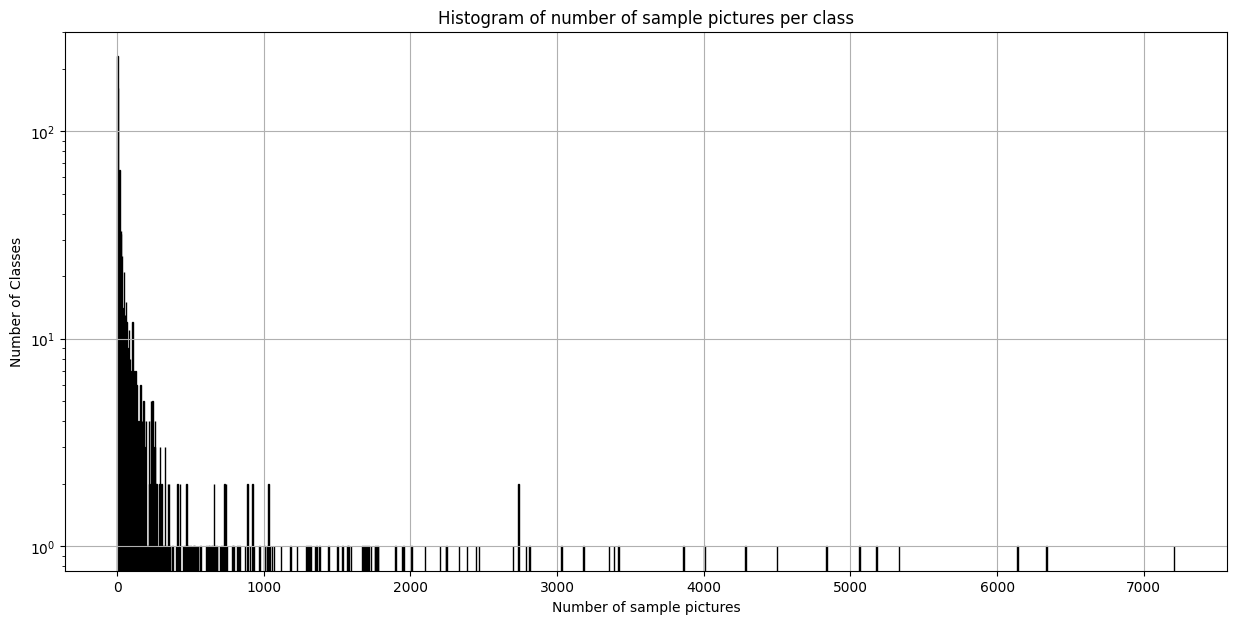

In [6]:
# Visualizing the distribution of images per class
plt.figure(figsize=(15, 7))
plt.hist(counts, bins=2000, color='green', edgecolor='black', log=True)  
plt.title('Histogram of number of sample pictures per class')
plt.xlabel('Number of sample pictures')
plt.ylabel('Number of Classes')
plt.grid(True)
plt.show()

# Setting up the Model

In [7]:
dataloaders = {
    data: DataLoader(image_datasets[data], batch_size=model_batch_size, shuffle=True, num_workers=model_num_workers) 
    for data in ['train', 'val']
}

In [8]:
# Model setup
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
number_of_features = model.fc.in_features # number of features in last layer
model.fc = nn.Linear(number_of_features, len(image_datasets['train'].classes)) # Replacing last layer with classes=no.of species


# Swithching to CUDA if possible
# Recommended to train the model faster, requires CUDA supported GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print("CUDA available: ",torch.cuda.is_available())
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

1
NVIDIA GeForce GTX 1660 Ti
CUDA available:  True


In [9]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=model_learning_rate, weight_decay=model_weight_decay)
optimizer = torch.optim.SGD(model.parameters(), lr=model_learning_rate, momentum=model_momentum, weight_decay=model_weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=model_step_size, gamma=model_gamma)

num_epochs =model_num_epochs


In [10]:
# Early stopper:
# Inspried and modified from: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    def __init__(self, patience=3, min_drop=0.03):
        self.patience = patience
        self.min_drop = min_drop
        self.counter = 0
        self.best_accuracy = 0

    def check_accuracy_drop(self, current_accuracy):
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.counter = 0
        elif self.best_accuracy - current_accuracy >= self.min_drop:
            self.counter += 1
            print("WARNING: accuracy dropped below minimum drop threshold!")
            if self.counter >= self.patience:
                return True
        return False

In [11]:

# Initialize lists to store per epoch metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize the best validation accuracy
best_val_acc = 0.0
best_epoch = 0
val_acc_history = []
early_stopper = EarlyStopper(patience=5, min_drop=0.02)

# Ensure the directory exists or create it
model_dir = os.path.dirname(model_save_path)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for epoch in range(num_epochs):
    # Training Phase
    epoch_start = time.time()
    model.train()  
    train_running_corrects = 0
    train_running_loss = 0.0

    train_progress = tqdm(dataloaders['train'], desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch')
    for inputs, labels in train_progress:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)

    train_epoch_loss = train_running_loss / len(image_datasets['train'])
    train_epoch_acc = train_running_corrects.double() / len(image_datasets['train'])
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc.item())

    # Validation Phase
    model.eval()  
    val_running_corrects = 0
    val_running_loss = 0.0

    val_progress = tqdm(dataloaders['val'], desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch')
    for inputs, labels in val_progress:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(image_datasets['val'])
    val_epoch_acc = val_running_corrects.double() / len(image_datasets['val'])
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_epoch = epoch

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_epoch_loss,
            'accuracy': best_val_acc.item(),
        }, model_save_path)
        
    epoch_duration = time.time() - epoch_start

    # Print statistics for the current epoch
    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1] * 100:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1] * 100:.2f}%, '
          f'Time: {epoch_duration:.2f}s\n')

    # Checking for early stopping
    if early_stopper.check_accuracy_drop(val_epoch_acc):
        print("WARNING: Early stopping triggered")
        break

print(f"Best model was from epoch {best_epoch + 1} with validation accuracy of {best_val_acc:.4f}")


Training Epoch 1/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 1/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 1/35 - Train Loss: 2.6414, Train Acc: 46.76%, Val Loss: 1.7647, Val Acc: 62.39%, Time: 1811.00s



Training Epoch 2/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 2/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 2/35 - Train Loss: 1.8795, Train Acc: 58.12%, Val Loss: 1.5205, Val Acc: 66.62%, Time: 1602.10s



Training Epoch 3/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 3/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 3/35 - Train Loss: 1.6706, Train Acc: 61.70%, Val Loss: 1.3664, Val Acc: 69.16%, Time: 1547.40s



Training Epoch 4/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 4/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 4/35 - Train Loss: 1.5515, Train Acc: 63.58%, Val Loss: 1.3063, Val Acc: 69.92%, Time: 1425.54s



Training Epoch 5/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 5/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 5/35 - Train Loss: 1.4635, Train Acc: 65.13%, Val Loss: 1.2267, Val Acc: 71.39%, Time: 1598.43s



Training Epoch 6/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 6/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 6/35 - Train Loss: 1.4036, Train Acc: 66.18%, Val Loss: 1.1950, Val Acc: 72.07%, Time: 1643.86s



Training Epoch 7/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 7/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 7/35 - Train Loss: 1.3497, Train Acc: 67.14%, Val Loss: 1.1516, Val Acc: 72.77%, Time: 1670.58s



Training Epoch 8/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 8/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 8/35 - Train Loss: 1.3062, Train Acc: 67.81%, Val Loss: 1.1153, Val Acc: 73.40%, Time: 1609.02s



Training Epoch 9/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 9/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 9/35 - Train Loss: 1.2686, Train Acc: 68.68%, Val Loss: 1.0819, Val Acc: 73.72%, Time: 1691.50s



Training Epoch 10/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 10/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 10/35 - Train Loss: 1.2402, Train Acc: 69.21%, Val Loss: 1.0714, Val Acc: 74.12%, Time: 1730.99s



Training Epoch 11/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 11/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 11/35 - Train Loss: 1.2185, Train Acc: 69.60%, Val Loss: 1.0727, Val Acc: 73.96%, Time: 1659.81s



Training Epoch 12/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 12/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 12/35 - Train Loss: 1.1917, Train Acc: 70.09%, Val Loss: 1.0318, Val Acc: 74.58%, Time: 1633.14s



Training Epoch 13/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 13/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 13/35 - Train Loss: 1.1710, Train Acc: 70.47%, Val Loss: 1.0420, Val Acc: 74.62%, Time: 1684.46s



Training Epoch 14/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 14/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 14/35 - Train Loss: 1.1491, Train Acc: 70.87%, Val Loss: 1.0068, Val Acc: 75.09%, Time: 1749.77s



Training Epoch 15/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 15/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 15/35 - Train Loss: 1.1335, Train Acc: 71.21%, Val Loss: 1.0058, Val Acc: 75.25%, Time: 1756.82s



Training Epoch 16/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 16/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 16/35 - Train Loss: 1.1194, Train Acc: 71.45%, Val Loss: 0.9880, Val Acc: 75.46%, Time: 1690.95s



Training Epoch 17/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 17/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 17/35 - Train Loss: 1.1014, Train Acc: 71.77%, Val Loss: 0.9971, Val Acc: 75.55%, Time: 2169.59s



Training Epoch 18/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 18/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 18/35 - Train Loss: 1.0916, Train Acc: 71.99%, Val Loss: 0.9781, Val Acc: 75.53%, Time: 1974.11s



Training Epoch 19/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 19/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 19/35 - Train Loss: 1.0781, Train Acc: 72.18%, Val Loss: 0.9980, Val Acc: 75.17%, Time: 1784.36s



Training Epoch 20/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 20/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 20/35 - Train Loss: 1.0668, Train Acc: 72.47%, Val Loss: 0.9735, Val Acc: 75.54%, Time: 1726.43s



Training Epoch 21/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 21/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 21/35 - Train Loss: 1.0556, Train Acc: 72.69%, Val Loss: 0.9592, Val Acc: 75.98%, Time: 1708.95s



Training Epoch 22/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 22/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 22/35 - Train Loss: 1.0435, Train Acc: 72.94%, Val Loss: 0.9614, Val Acc: 76.16%, Time: 1720.88s



Training Epoch 23/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 23/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 23/35 - Train Loss: 1.0345, Train Acc: 73.08%, Val Loss: 0.9495, Val Acc: 76.16%, Time: 1583.60s



Training Epoch 24/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 24/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 24/35 - Train Loss: 1.0264, Train Acc: 73.26%, Val Loss: 0.9393, Val Acc: 76.22%, Time: 1586.23s



Training Epoch 25/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 25/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 25/35 - Train Loss: 1.0150, Train Acc: 73.46%, Val Loss: 0.9483, Val Acc: 76.29%, Time: 1578.71s



Training Epoch 26/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 26/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 26/35 - Train Loss: 1.0153, Train Acc: 73.47%, Val Loss: 0.9490, Val Acc: 76.18%, Time: 1584.42s



Training Epoch 27/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 27/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 27/35 - Train Loss: 1.0027, Train Acc: 73.68%, Val Loss: 0.9296, Val Acc: 76.65%, Time: 1579.39s



Training Epoch 28/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 28/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 28/35 - Train Loss: 0.9978, Train Acc: 73.90%, Val Loss: 0.9347, Val Acc: 76.49%, Time: 1586.95s



Training Epoch 29/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 29/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 29/35 - Train Loss: 0.9923, Train Acc: 73.98%, Val Loss: 0.9242, Val Acc: 76.73%, Time: 1625.04s



Training Epoch 30/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 30/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 30/35 - Train Loss: 0.9823, Train Acc: 74.23%, Val Loss: 0.9248, Val Acc: 76.51%, Time: 1753.30s



Training Epoch 31/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 31/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 31/35 - Train Loss: 0.9767, Train Acc: 74.31%, Val Loss: 0.9351, Val Acc: 76.26%, Time: 1762.36s



Training Epoch 32/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 32/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 32/35 - Train Loss: 0.9715, Train Acc: 74.33%, Val Loss: 0.9080, Val Acc: 76.95%, Time: 1762.39s



Training Epoch 33/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 33/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 33/35 - Train Loss: 0.9657, Train Acc: 74.52%, Val Loss: 0.9226, Val Acc: 76.81%, Time: 1760.07s



Training Epoch 34/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 34/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 34/35 - Train Loss: 0.9585, Train Acc: 74.63%, Val Loss: 0.9071, Val Acc: 76.92%, Time: 1763.34s



Training Epoch 35/35:   0%|          | 0/15245 [00:00<?, ?batch/s]

Validation Epoch 35/35:   0%|          | 0/1945 [00:00<?, ?batch/s]

Epoch 35/35 - Train Loss: 0.9548, Train Acc: 74.67%, Val Loss: 0.9118, Val Acc: 76.96%, Time: 1764.45s

Best model was from epoch 35 with validation accuracy of 0.7696


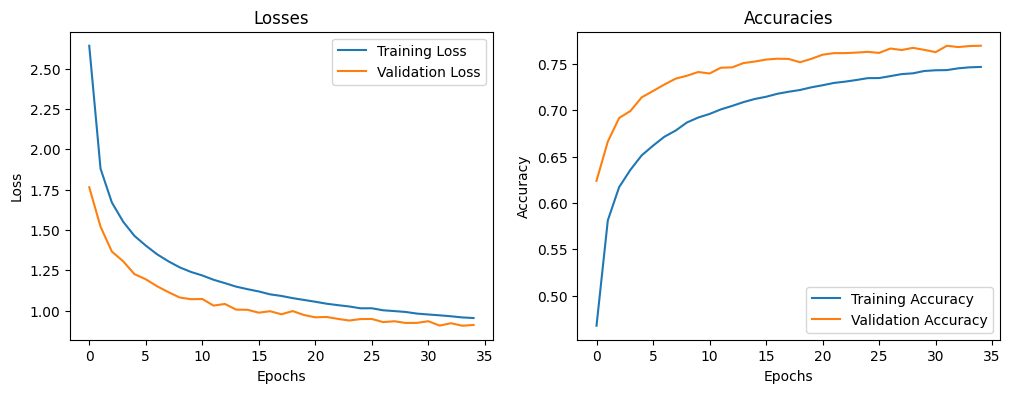

In [12]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- **Model Architecture**: Pre-trained ResNet18
- **Batch Size**: 16
- **Number of Workers**: 4
- **Loss Function**: Cross-Entropy Loss
- **Optimizer**: SGD (Learning Rate: 0.001, Momentum: 0.9)
- **Learning Rate Scheduler**: StepLR (Step Size: 6, Gamma: 0.1)
- **Number of Epochs**: 35
- **Device**: CUDA (if available)

In [ ]:
# Defining Dataset directory and transformation settings
model_dataset_dir = './images/'
model_batch_size = 16
model_num_workers = 4

# Training settings
model_num_epochs = 35
model_learning_rate = 0.001
model_momentum = 0.9
model_weight_decay=1e-4

# Scheduler settings
model_step_size = 6
model_gamma = 0.1
